# Read in the data

In [1]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

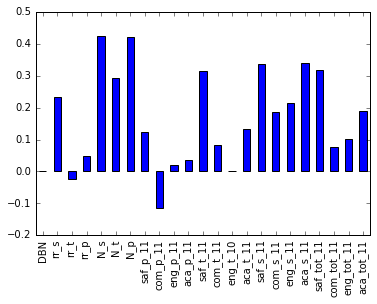

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

survey_correlations = combined.corr()["sat_score"][survey_fields]
survey_correlations.plot.bar()


All of the categories for number of respondants -- parents, students, and teachers -- correlate moderately positively with SAT scores.  This may be because schools with more engagement on behalf of everyone tend to have better results.  It also may be that there are circumstances such as wealth that are allowing those types of schools to respond more to surveys, and it is actually a factor like wealth that is affecting the SAT scores.

The academic expectations of students correlate positively with SAT scores, but not the academic expectations of teachers and parents.  That may be because students have a better understanding of how hard they are working, and when they are working hard they both perceive that there are high academic expectations, and eventually score better on the SAT because they are studying harder.

We also see a positive correlation between safety and sat scores.  This may be due to covariance.  Schools that are perceived as less safe may have less resources and worse education, which results in lower sat scores.  Conversely schools with high levels of safety may have better resources leading to better education and higher sat scores.

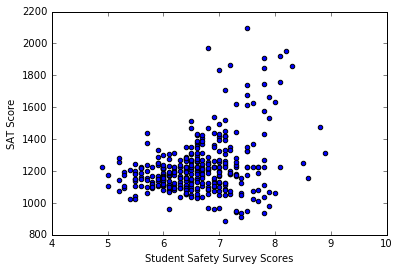

In [22]:
plt.scatter(combined["saf_s_11"],combined["sat_score"])
plt.xlabel("Student Safety Survey Scores")
plt.ylabel("SAT Score")
plt.show()

we see generally a positive relationship between student safety score and SAT score.  However, we can interestingly note that at the 7-8 range of safety, we see both the highest and the lowest SAT scores.  scores for schools with higher than 8.5 come down significantly, though the sample size of those schools is small.

In [24]:
import numpy as np

districts = combined.groupby("school_dist").agg(np.mean)
districts.reset_index(inplace=True)

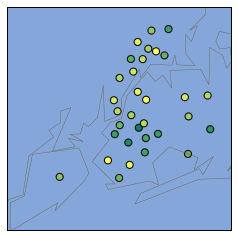

In [31]:
from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

m.scatter(longitudes, latitudes, latlon=True, c=districts["saf_s_11"], cmap="summer",s=50)



In [34]:
race_columns = ["white_per", "asian_per", "black_per", "hispanic_per"]

correlations = combined.corr()["sat_score"][race_columns]
correlations

white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
Name: sat_score, dtype: float64

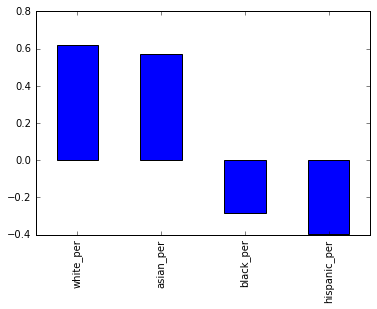

In [39]:
correlations.plot.bar()

Based on the correlations of race with sat scores, it looks like whites and asians do better on the SAT, whereas black and hispanics do worse.  The correlation is more strongly positive for whites and asians than it is negative for blacks and hispanics.

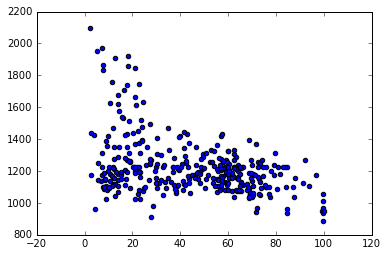

In [40]:
plt.scatter(combined["hispanic_per"],combined["sat_score"])
plt.show()

There is a clear negative correlation between hispanic percentage and SAT scores.  Interestingly, there is a strong dropoff around 25%.  After this point, SAT scores don't go down nearly as significantly even with very high hispanic percentages.  Though we do so a concentration of very poor performing schools that are at or near 100% hispanic.

In [44]:
hispanic_per_95 = combined[combined["hispanic_per"] > 95]
print(hispanic_per_95[["SCHOOL NAME","hispanic_per"]])

                                           SCHOOL NAME  hispanic_per
44                       MANHATTAN BRIDGES HIGH SCHOOL          99.8
82    WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL          96.7
89   GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...          99.8
125                ACADEMY FOR LANGUAGE AND TECHNOLOGY          99.4
141              INTERNATIONAL SCHOOL FOR LIBERAL ARTS          99.8
176   PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE          99.8
253                          MULTICULTURAL HIGH SCHOOL          99.8
286             PAN AMERICAN INTERNATIONAL HIGH SCHOOL         100.0


In [46]:
hispanic_per_10 = combined[combined["hispanic_per"] < 10]
hispanic_10_sat_1800 = hispanic_per_10[hispanic_per_10["sat_score"]>1800]
print(hispanic_10_sat_1800[["SCHOOL NAME","hispanic_per","sat_score"]])

                                           SCHOOL NAME  hispanic_per  \
37                              STUYVESANT HIGH SCHOOL           2.4   
151                       BRONX HIGH SCHOOL OF SCIENCE           7.2   
187                     BROOKLYN TECHNICAL HIGH SCHOOL           7.9   
327  QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...           7.9   
356                STATEN ISLAND TECHNICAL HIGH SCHOOL           5.3   

     sat_score  
37      2096.0  
151     1969.0  
187     1833.0  
327     1868.0  
356     1953.0  


All of the schools in New York that have less than 10% hispanic students and an average SAT score over 1800 are in a group of "specialized" schools that are specifically tailored toward the needs of gifted students.

https://en.wikipedia.org/wiki/Specialized_high_schools_in_New_York_City

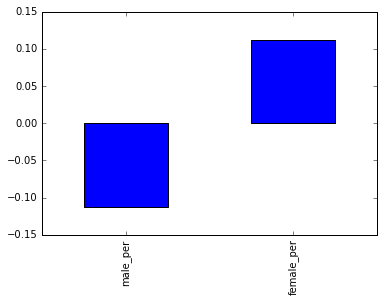

In [47]:
gender_corr = combined.corr()["sat_score"][["male_per","female_per"]]
gender_corr.plot.bar()

Male percentage correlates negatively with SAT score, and female percentage correlates positively.  This indicates that females do better on the SAT than men, although the correlation is weak.

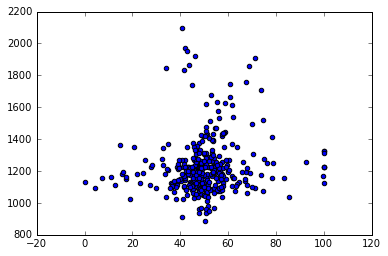

In [49]:
plt.scatter(combined["female_per"],combined["sat_score"])
plt.show()

While there appears to be a weak positive correlation between female % and SAT score, the strongest SAT score schools actually have less than 50% women.  SAT scores correlate more positively with female % up to around 75%, but after that there's a dropoff, and schools with between 90% and 100% perform pretty similarly to schools with 0% - 30% women.

In [50]:
female_per_60 = combined[combined["female_per"] > 60]
female_per_60 = female_per_60[female_per_60["sat_score"]>1700]
print(female_per_60[["SCHOOL NAME", "sat_score", "female_per"]])

                                           SCHOOL NAME  sat_score  female_per
5                       BARD HIGH SCHOOL EARLY COLLEGE     1856.0        68.7
26                       ELEANOR ROOSEVELT HIGH SCHOOL     1758.0        67.5
60                                  BEACON HIGH SCHOOL     1744.0        61.0
61   FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...     1707.0        73.6
302                        TOWNSEND HARRIS HIGH SCHOOL     1910.0        71.1


These schools are all small, very selective schools that lean towards liberal educations.

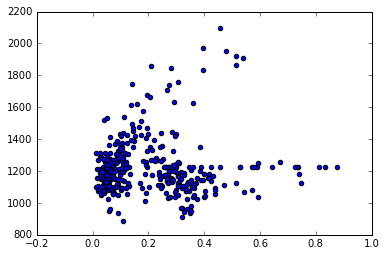

In [51]:
combined["ap_per"] = combined["AP Test Takers "]/combined["total_enrollment"]
plt.scatter(combined["ap_per"],combined["sat_score"])
plt.show()



In [54]:
import scipy.stats

r, p = scipy.stats.pearsonr(combined["ap_per"],combined["sat_score"])
r

0.057170813907669669

We see a positive correlation between percentage of students who take an AP exam and SAT score, however as we can see from the pearson r score, the co